# 게임 회사 데이터 분석
#### Golas : 다음 분기에 어떤 게임을 설계해야할까
1. 지역에 따라 선호하는 게임 장르가 다를까
2. 연도별 게임의 트렌드가 있을까
3. 출고량이 높은 게임에 대한 분석 및 시각화

- Dataset
  - Name : 게임의 이름
  - Platform : 게임이 지원되는 플랫폼의 이름
  - Year : 게임이 출시된 연도
  - Genre : 게임의 장르
  - Publisher : 게임을 제작한 회사
  - NA_Sales : 북미지역에서의 출고량
  - EU_Sales : 유럽지역에서의 출고량
  - JP_Sales : 일본지역에서의 출고량
  - Other_Sales : 기타지역에서의 출고량



#### 데이터 불러오기

In [3]:
# 사용 라브러리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

In [4]:
# 데이터 불러오기
url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv"
df = pd.read_csv(url)
df = df.iloc[:,1:] 
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [6]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [9]:
df.select_dtypes('object').describe()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16598,16598,16548,16540,16598,16598,16598,16598
unique,11493,31,12,578,494,363,282,190
top,Need for Speed: Most Wanted,DS,Action,Electronic Arts,0,0,0,0
freq,12,2163,3305,1351,4443,5665,10333,6386


#### Preprocessing

##### 1. 결측치 처리
- Year : 크롤링을 통해 넣어줌
- Genre / Publisher 는 추후 처리 방안 확인

In [4]:
# # 출시일 크롤링

# import requests
# from bs4 import BeautifulSoup
# import time

# def getPageString(url, keywords):
#   url = url + keywords
  
#   data = requests.get(url, headers=header)
#   return data.text

# header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36'}
# url = 'https://www.google.com/search?q='

# names = df.loc[df["Year"].isnull() > 0,:]["Name"].to_list()
# result = dict()

# for idx,name in enumerate(names):
#   res = getPageString(url,name)
#   soup = BeautifulSoup(res, 'lxml')
#   time.sleep(3)
#   date = soup.select_one('div > span.LrzXr.kno-fv.wHYlTd.z8gr9e')
#   if date:
#     result[idx] = [name,date.text]
#   else:
#     result[idx] = [name,None]


In [5]:
# # 나중에 사용할 수 있어 데이터 저장해두기
# pd.DataFrame(result.items(),
#              columns=['idx','result']).to_csv("/content/drive/MyDrive/Colab Notebooks/codestates/Year_Crawling.csv",
#              sep=',')

In [34]:
## drive에 저장된 데이터 불러오기
import ast  # 문자로 되어있는 리스트를 리스트 형태로 변환시켜주는 라이브러리
result = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/codestates/Year_Crawling.csv")
result = result.iloc[:,1:]

crawl = result
crawl['result'] = crawl['result'].apply(lambda x: ast.literal_eval(x))
crawl['Name'] = crawl['result'].apply(lambda x: x[0])
crawl['Year'] = crawl['result'].apply(lambda x: x[1])

In [35]:

month = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
join_month = '|'.join(month)         

def check_month(x):
  if x != None:
    if x.split(" ")[0] in month:
      return x.split(", ")[1][:4]
  return None

crawl['Year'] = crawl['Year'].apply(check_month)


In [36]:
crawl = crawl.drop(['result'], axis=1)
crawl.head()

,idx,Name,Year
0,0,Rock Band,2007
1,1,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),None
2,2,Jewel Link Chronicles: Mountains of Madness,2012
3,3,Majesty 2: The Fantasy Kingdom Sim,2009
4,4,Famista 64,1997


In [37]:
year_chg = df.loc[df["Year"].isnull() > 0,:].reset_index().reset_index()
year_chg = year_chg.merge(crawl,
                          how='left',
                          left_on='level_0',
                          right_on='idx')

year_chg.drop(['level_0','Name_y','Year_x','idx'],axis=1,inplace=True)
year_chg.rename({'Name_x':'Name','Year_y':'Year'},axis=1,inplace=True)
year_chg.set_index('index',inplace=True)

In [38]:
drop_index = df[df["Year"].isnull() > 0].index
df.drop(drop_index,inplace=True)

In [39]:
df = pd.concat([df,year_chg])

In [40]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [41]:
df.isnull().sum()

Name            0
Platform        0
Year           76
Genre          50
Publisher      58
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

In [42]:
# 결측치 처리 -> 나머지 결측 데이터는 삭제
df.dropna(inplace=True)

##### 2. 출고량 단위 통일
- 'K'포함 : 1000 곱함
- 나머지 : 1000000 곱함
  - 'M'포함 : 'M' 삭제
- float 처리

== 단위 : (개)

In [45]:
# 출고량 데이터 
# M, K 단위 값이 들어가 있어 이를 처리해줄 예정이다
# M : M 만 삭제 , K : 0.001 으로 계산

def sales_preprocessing(x):

  if type(x) is float:
    return x

  if 'K' in x:
    return float(x.replace("K","")) * 1000
  elif 'M' in x:
    return float(x.split("M")[0]) * 1000000
  else:
    return float(x)  * 1000000

sales = df.columns[df.columns.str.contains("_Sales")]
for idx in sales:
  df[idx] = df[idx].apply(sales_preprocessing)
  
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16426 entries, 0 to 16432
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16426 non-null  object 
 1   Platform     16426 non-null  object 
 2   Year         16426 non-null  object 
 3   Genre        16426 non-null  object 
 4   Publisher    16426 non-null  object 
 5   NA_Sales     16426 non-null  float64
 6   EU_Sales     16426 non-null  float64
 7   JP_Sales     16426 non-null  float64
 8   Other_Sales  16426 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.3+ MB


##### 3. Year 값 확인

1. 년도가 9,97,3,4,.. 등 yyyy의 형태로 들어가있지 않음

In [46]:
df['Year'].astype(int).astype(str).unique()

array(['2008', '2009', '2010', '2005', '2011', '2007', '2001', '2003',
       '2006', '2014', '2015', '2002', '1997', '2013', '1996', '2004',
       '2000', '1984', '1998', '2016', '1985', '1999', '9', '97', '1995',
       '1993', '2012', '1987', '1982', '11', '1994', '1990', '15', '1992',
       '1991', '1983', '1988', '1981', '3', '1989', '96', '6', '8',
       '1986', '1', '5', '4', '10', '98', '7', '16', '86', '14', '95',
       '2017', '1980', '2020', '2', '13', '0', '12', '94', '1975', '2018'],
      dtype=object)

In [47]:
def year_preprocessing(x):
  if len(str(x))<3:
    if x < 20:
      return 2000 + x
    else:
      return 1900 + x
  return x



df['Year'] = df['Year'].astype(int)
df['Year'] = df['Year'].apply(year_preprocessing)

- df['Year']의 값이 2자리 이하 즉, 0 ~ 99 의 경우 앞의 년도가 누락되어있다.
- 앞의 년도가 누락된 데이터는 38개, 이를 결측처리할지 여부 확인
- 2자리 이하 중 최대 값은 99, 최소값은 0이다. 
- 20 이하의 값은 2000년대, 이상의 값은 1900년대의 데이터로 전처리 진행 


#### Feature Engineering

##### 1. Total_Sales 생성
- Total_Sales : NA, EU, JP, Other 출고량 합

In [48]:
df['TotalSales'] = df.loc[:,df.columns.str.contains('_Sales')].sum(axis=1)
df['TotalSales']

0         40000.0
1        180000.0
2         20000.0
3         40000.0
4        250000.0
           ...   
15897     10000.0
16240     10000.0
16278    750000.0
16425     60000.0
16432    140000.0
Name: TotalSales, Length: 16426, dtype: float64

2. Year 10년 단위로 Group

In [111]:

## Year Binning
bins = [df['Year'].min()-1,1990,2000,2010,df['Year'].max()+1]
df['Year_binning'] = pd.cut(df['Year'], 
                                bins=bins,
                                right=False,
                                labels=['1980~1989','1990~1999','2000~2009','2010~'])
  


#### 분석

##### 1. 지역에 따라 선호하는 게임 장르가 다를까


- 지역 별 전체 출고량(Total Sales) 기준으로 어떤 지역의 출고량이 높은지 살펴 보았다.

In [67]:
# 지역 별 출고량 차이 보기

total = df.groupby(['Year'])\
          ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','TotalSales']\
          .sum()\
          .reset_index()

columns = total.columns[total.columns.str.contains("_Sales")]
for c in columns:
  total[c+'_ratio'] = round((total[c] / total['TotalSales']) * 100,2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


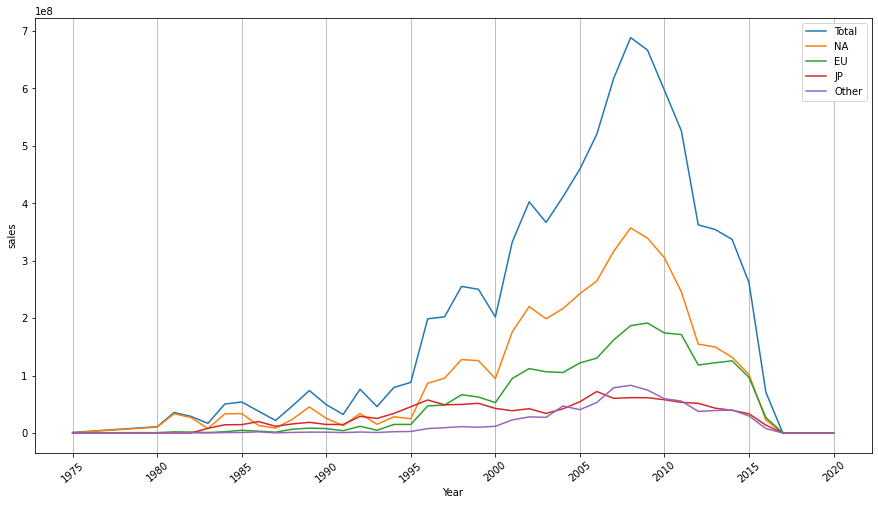

In [75]:
# 출고량 기준
plt.figure(figsize=(15,8))
sns.lineplot(data=total, x='Year',y='TotalSales', label='Total')
sns.lineplot(data=total, x='Year',y='NA_Sales', label='NA')
sns.lineplot(data=total, x='Year',y='EU_Sales', label='EU')
sns.lineplot(data=total, x='Year',y='JP_Sales', label='JP')
sns.lineplot(data=total, x='Year',y='Other_Sales', label='Other')

plt.xticks([y for y in range(total['Year'].min(),total['Year'].max()+1,5)],rotation=40)
plt.ylabel("sales")
plt.legend(loc='best')
plt.grid(True,axis='x')

In [76]:
total.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,NA_Sales_ratio,EU_Sales_ratio,JP_Sales_ratio,Other_Sales_ratio
count,41.000000,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,41.000000,41.000000,41.000000,41.000000
mean,1998.926829,1.061112e+08,5.888122e+07,3.113854e+07,1.929146e+07,2.154224e+08,51.252927,20.220976,22.717805,5.807805
std,12.203258,1.086645e+08,6.376256e+07,2.171693e+07,2.490009e+07,2.135089e+08,18.640132,11.318587,20.601613,4.298368
min,1975.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+04,0.000000,0.000000,0.000000,0.000000
25%,1989.000000,2.266000e+07,3.100000e+06,1.427000e+07,7.400000e+05,3.790000e+07,42.250000,10.110000,9.770000,2.030000
50%,1999.000000,4.535000e+07,2.676000e+07,3.399000e+07,7.660000e+06,8.811000e+07,50.340000,24.040000,14.260000,4.550000
75%,2009.000000,1.760700e+08,1.121500e+08,4.975000e+07,3.762000e+07,3.623100e+08,52.950000,28.530000,30.140000,10.380000
max,2020.000000,3.570100e+08,1.913900e+08,7.219000e+07,8.302000e+07,6.883600e+08,93.610000,37.890000,100.000000,12.750000


In [81]:
total[total['Year']>=2010].describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,NA_Sales_ratio,EU_Sales_ratio,JP_Sales_ratio,Other_Sales_ratio
count,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.00000,10.000000,10.000000,10.000000
mean,2014.600000,1.112000e+08,8.353900e+07,2.926900e+07,2.694300e+07,2.509510e+08,46.92500,25.765000,19.008000,8.302000
std,3.204164,1.077263e+08,7.050784e+07,2.362648e+07,2.327790e+07,2.228647e+08,25.95899,14.890459,29.076117,4.576065
min,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+04,0.00000,0.000000,0.000000,0.000000
25%,2012.250000,5.867500e+06,6.697500e+06,3.455000e+06,1.952500e+06,1.792750e+07,38.95500,19.800000,9.807500,7.672500
50%,2014.500000,1.168950e+08,1.076150e+08,3.644500e+07,3.363500e+07,2.994550e+08,42.47500,32.610000,11.960000,10.480000
75%,2016.750000,1.534600e+08,1.247775e+08,4.956500e+07,3.979250e+07,3.602975e+08,50.02000,36.390000,13.887500,11.015000
max,2020.000000,3.050200e+08,1.741600e+08,5.787000e+07,5.962000e+07,5.966700e+08,93.10000,37.780000,100.000000,11.870000


In [83]:
total[(total['Year']>=2000) & (total['Year']<2010)].describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,NA_Sales_ratio,EU_Sales_ratio,JP_Sales_ratio,Other_Sales_ratio
count,10.00000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,2004.50000,2.426100e+08,1.264300e+08,5.098100e+07,4.668300e+07,4.667040e+08,51.908000,27.093000,11.651000,9.348000
std,3.02765,8.009441e+07,4.298029e+07,1.258005e+07,2.525274e+07,1.563732e+08,2.193707,1.390748,3.674868,2.502549
min,2000.00000,9.470000e+07,5.287000e+07,3.405000e+07,1.164000e+07,2.019800e+08,46.890000,25.050000,8.930000,5.760000
25%,2002.25000,2.033225e+08,1.055900e+08,4.218500e+07,2.741000e+07,3.756250e+08,50.970000,26.197500,9.410000,7.067500
50%,2004.50000,2.313150e+08,1.170650e+08,4.857500e+07,4.381500e+07,4.353550e+08,52.285000,26.840000,10.380000,9.520000
75%,2006.75000,3.034050e+08,1.541250e+08,6.112750e+07,6.932250e+07,5.931250e+08,52.910000,28.365000,11.787500,11.382500
max,2009.00000,3.570100e+08,1.913900e+08,7.219000e+07,8.302000e+07,6.883600e+08,54.670000,29.060000,21.180000,12.750000


In [94]:
y2000 = '{:.20f}'.format(4.667040e+08)
y2010 = '{:.20f}'.format(2.509510e+08)
print(format(float(y2000),','))
print(format(float(y2010),','))

(float(y2000) - float(y2010)) / float(y2000)

466,704,000.0
250,951,000.0


0.4622908738729473

- 2010년 이후 기준, NA, EU 의 출고량이 전체 출고량의 약 72% 를 차지하고 있음
- 2009년 이후 게임 시장이 하락세를 보임
- 실제 2000년대와 2010년대의 출고량 평균을 보면 약 46% 감소한 것으로 보임
  - 2000~2009년 전체 출고량 평균 약 466,704,000 개
  - 2010년 이후 전체 출고량 평균 약 250,951,000 개


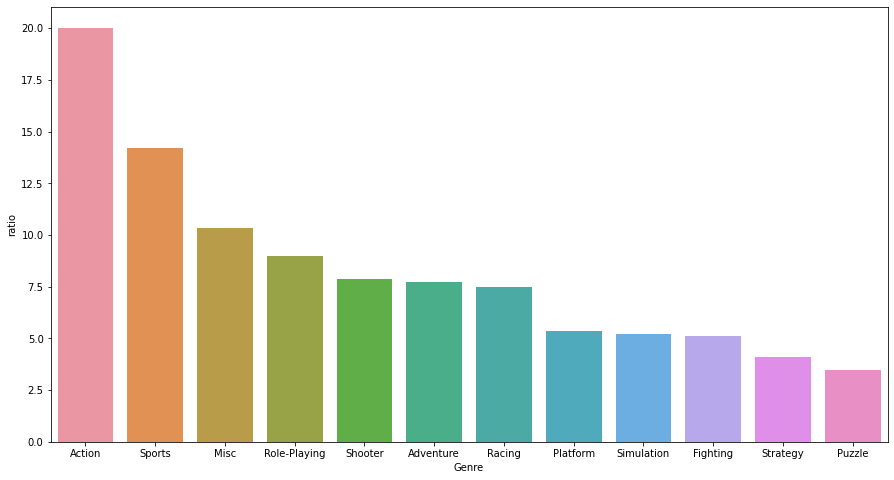

In [336]:
# 장르별 출고량 수
genre_cnt = df.reset_index().groupby(['Genre'])['index'].count().sort_values(ascending=False)
total_cnt = df.shape[0]
genre_ratio = (genre_cnt / total_cnt) * 100
genre_ratio = pd.DataFrame(genre_ratio).rename({'index':'ratio'},axis=1).reset_index()

plt.figure(figsize=(15,8))
ax = sns.barplot(data=genre_ratio,
            x = 'Genre',
            y = 'ratio')


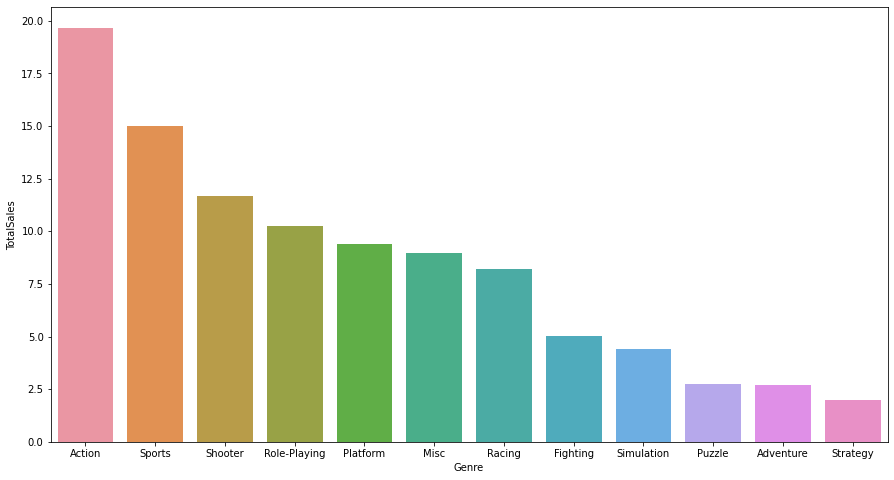

In [340]:
# 장르별 출고량 수
genre_sales = df.reset_index().groupby(['Genre'])['TotalSales'].sum().sort_values(ascending=False)
total_sales = df['TotalSales'].sum()
genre_sales_ratio = (genre_sales / total_sales) * 100
genre_sales_ratio = pd.DataFrame(genre_sales_ratio).reset_index()

plt.figure(figsize=(15,8))
ax = sns.barplot(data=genre_sales_ratio,
            x = 'Genre',
            y = 'TotalSales')


#### 장르별 지역에 따른 출고량 차이가 있는지 살펴보자.

In [105]:
# 장르별 지역에 따른 출고량 차이 보기

genre_region_total = df.groupby(['Genre'])\
                      ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','TotalSales']\
                      .sum().reset_index()

genre_region_mean = df.groupby(['Genre'])\
                      ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','TotalSales']\
                      .mean().reset_index()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


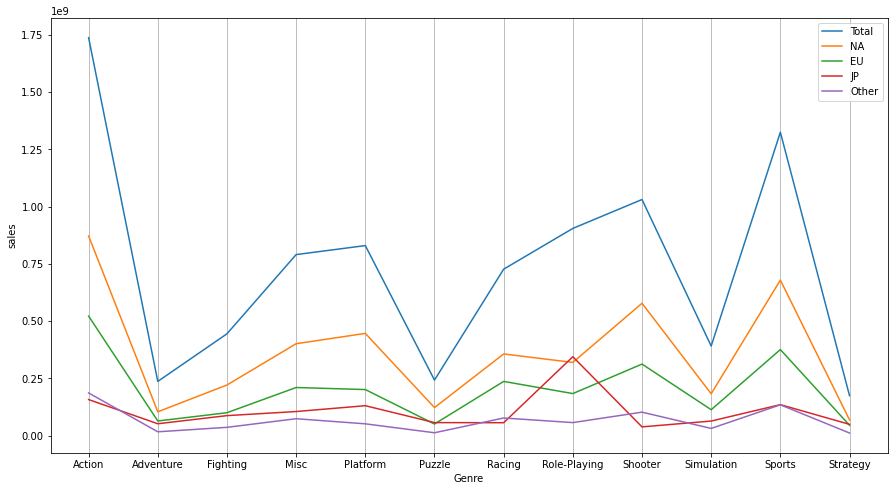

In [106]:

# 장르별 지역에 따른 출고량 전체 Total, SUM
plt.figure(figsize=(15,8))
sns.lineplot(data=genre_region_total, x='Genre',y='TotalSales', label='Total')
sns.lineplot(data=genre_region_total, x='Genre',y='NA_Sales', label='NA')
sns.lineplot(data=genre_region_total, x='Genre',y='EU_Sales', label='EU')
sns.lineplot(data=genre_region_total, x='Genre',y='JP_Sales', label='JP')
sns.lineplot(data=genre_region_total, x='Genre',y='Other_Sales', label='Other')

plt.ylabel("sales")
plt.legend(loc='best')
plt.grid(True,axis='x')

- 출고량의 합으로 장르별 지역의 차이를 살펴보았을 때, Action, Sports, Shooter 게임의 인기가 있어 보인다. 
- 하지만 게임의 출시 수가 Action, Sports 에서 많았기 때문에, Mean 값으로 그래프를 확인하는 것이 맞다고 판단하였다.

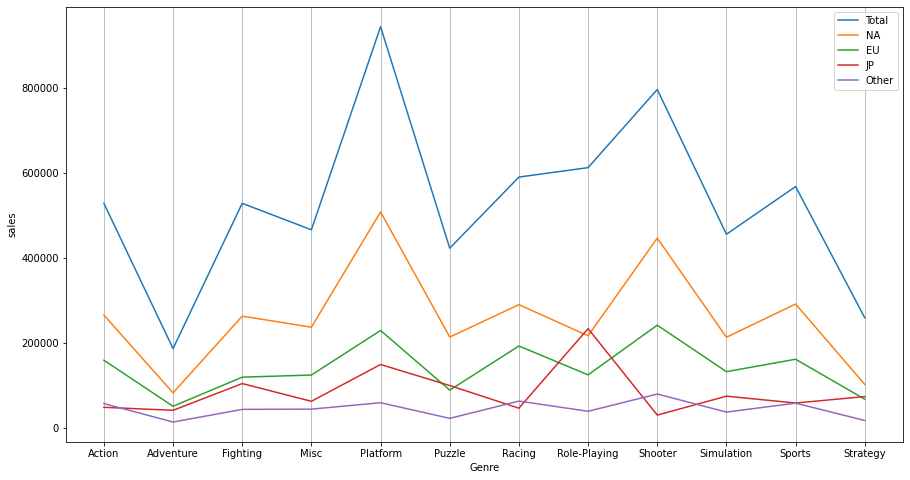

In [108]:

# 장르별 지역에 따른 게임 하나당 출고량
plt.figure(figsize=(15,8))
sns.lineplot(data=genre_region_mean, x='Genre',y='TotalSales', label='Total')
sns.lineplot(data=genre_region_mean, x='Genre',y='NA_Sales', label='NA')
sns.lineplot(data=genre_region_mean, x='Genre',y='EU_Sales', label='EU')
sns.lineplot(data=genre_region_mean, x='Genre',y='JP_Sales', label='JP')
sns.lineplot(data=genre_region_mean, x='Genre',y='Other_Sales', label='Other')

plt.ylabel("sales")
plt.legend(loc='best')
plt.grid(True,axis='x')

- Mean 값으로 계산된 결과를 확인해보면, 게임 하나당 출고량이 높은 장르는 Platform, Shooter, RolePlaying 으로 확인된다.
- 앞서 전체 Total 값으로 확인했을 때는, Action이 앞도적으로 높았지만, 이는 출시된 게임 수가 많아서 합계에 영향을 준 것으로 보인다.

In [382]:
# 전체, 지역별 출고량 Mean 가져오기
# 해당 코드 사용 X
def sales(r):
  genre_sum = df.groupby('Genre')[r].sum() # SUM 기준 
  genre_mean = df.groupby('Genre')[r].mean() # Mean 기준
  # total = df.groupby('Genre')[r].mean().sum()
  total = df.groupby('Genre')[r].sum().sum()
  return pd.DataFrame(genre_mean), pd.DataFrame(round((genre_sum / total) * 100,2)), pd.DataFrame(genre_sum)


releaseBYregion_ratio = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])
releaseBYregion_mean = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])
releaseBYregion_sum = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])

region = df.columns[df.columns.str.contains('Sales')]
for r in region:
  mean, ratio, sum = sales(r)
  
  ratio.sort_values(ascending=False,inplace=True, by=[r])

  # 장르별 선호 비율
  releaseBYregion_ratio = releaseBYregion_ratio.merge(ratio,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=ratio.index)
  
  releaseBYregion_mean = releaseBYregion_mean.merge(mean,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=mean.index)
  
  releaseBYregion_sum = releaseBYregion_sum.merge(sum,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=sum.index)
  
  # 7순위 이후의 데이터는 Others로 묶어서 좀
  # others = pd.DataFrame([ratio[r][7:].sum()],
  #                       columns=[r],
  #                       index=['Others'])

  # ratio = pd.concat([ratio[:7],others])
  

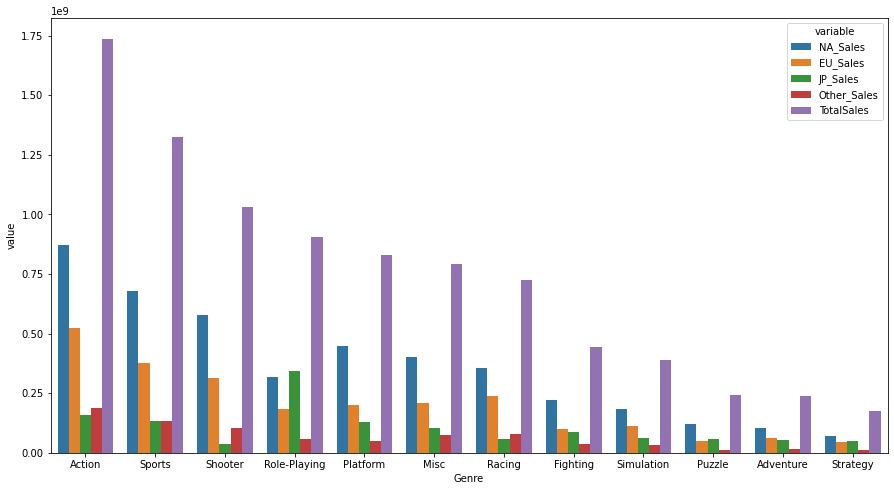

In [383]:
## 전체 출고량 N수 기준으로 본 데이터
plt.figure(figsize=(15,8))

ax = sns.barplot(data=releaseBYregion_sum.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


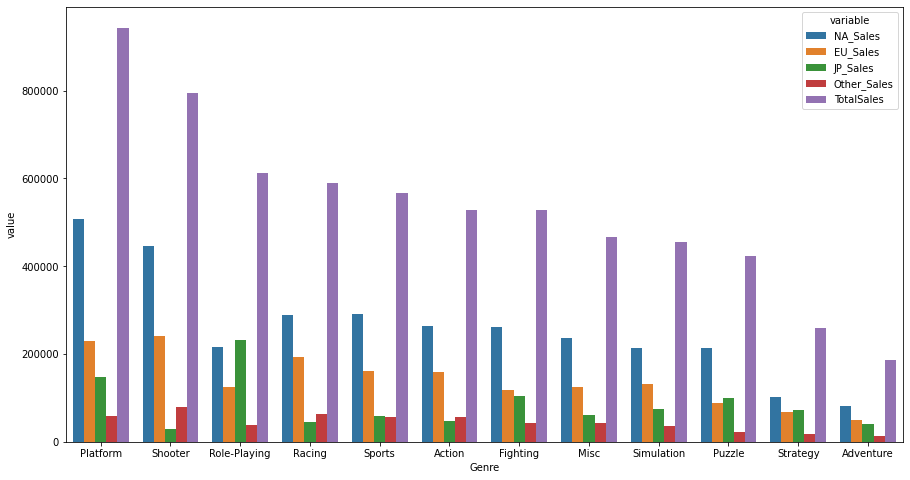

In [129]:
## 지역별 장르에 따른 게임 1개당 출고량
plt.figure(figsize=(15,8))
ax = sns.barplot(data=releaseBYregion_mean.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


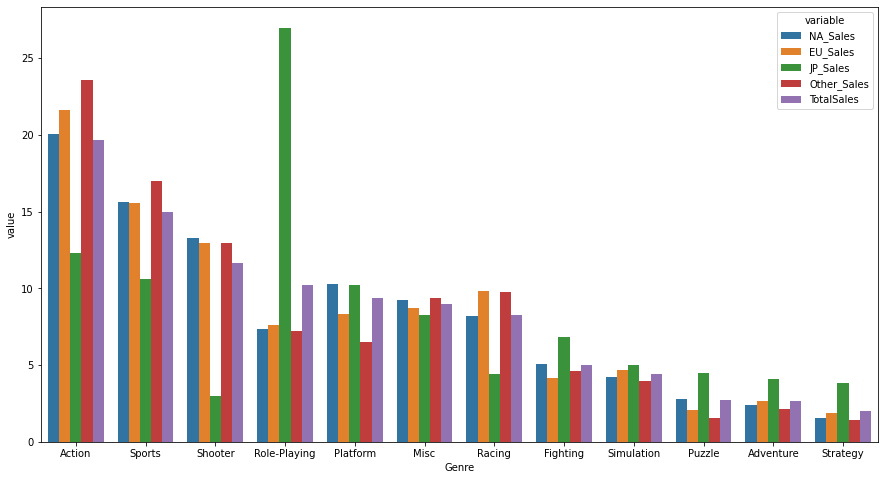

In [384]:
## 지역별 장르에 따라 출고된 비율
plt.figure(figsize=(15,8))
ax = sns.barplot(data=releaseBYregion_ratio.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


- 전체 출고량 Total로 확인해 보면 Action 장르가 강세로 보이지만 이는 출시 게임수의 영향으로 보임
- 지역별 장르의 출고 비율은 비슷한 수준으로 보임
- 다만 일본 지역에서 Role-Playing 장르가 강세로 보이지만, 전체 출고량으로 보았을 때는 다른 지역에 비해 월등히 높은 수준은 아님 

#### 2010 년 이후 데이터를 기준으로 장르별 지역에 따른 출고량 차이

In [379]:
# 전체, 지역별 출고량 Mean 가져오기
# 해당 코드 사용 X
def sales(r):
  cond = (df['Year_binning']=='2010~')
  genre_sum = df[cond].groupby('Genre')[r].sum() # SUM 기준 
  genre_mean = df[cond].groupby('Genre')[r].mean() # Mean 기준
  total = df[cond].groupby('Genre')[r].sum().sum()
  # total = df[cond].groupby('Genre')[r].mean().sum()
  return pd.DataFrame(genre_mean), pd.DataFrame(round((genre_sum / total) * 100,2)), pd.DataFrame(genre_sum)


releaseBYregion_2010_ratio = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])
releaseBYregion_2010_mean = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])
releaseBYregion_2010_sum = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])

region = df.columns[df.columns.str.contains('Sales')]
for r in region:
  mean, ratio, sum = sales(r)
  
  ratio.sort_values(ascending=False,inplace=True, by=[r])

  # 장르별 선호 비율
  releaseBYregion_2010_ratio = releaseBYregion_2010_ratio.merge(ratio,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=ratio.index)
  
  releaseBYregion_2010_mean = releaseBYregion_2010_mean.merge(mean,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=mean.index)
  
  releaseBYregion_2010_sum = releaseBYregion_2010_sum.merge(sum,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=sum.index)
  
  # 7순위 이후의 데이터는 Others로 묶어서 좀
  # others = pd.DataFrame([ratio[r][7:].sum()],
  #                       columns=[r],
  #                       index=['Others'])

  # ratio = pd.concat([ratio[:7],others])
  

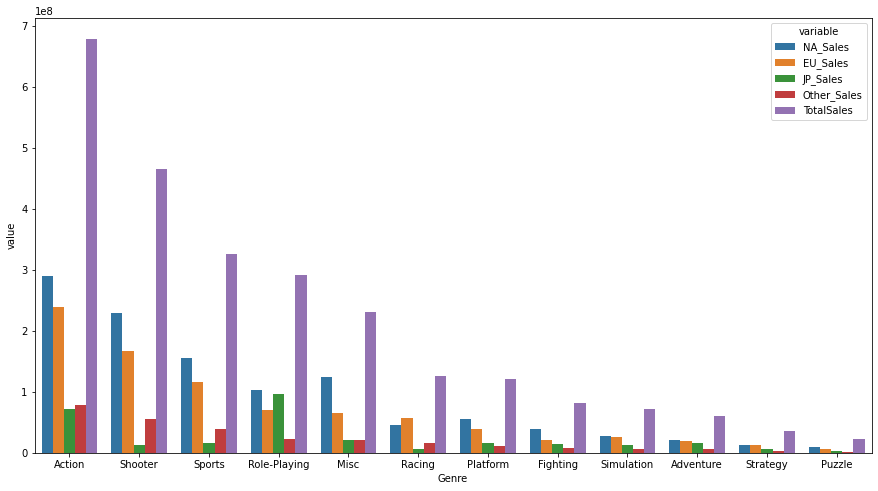

In [373]:
## 전체 출고량 N수 기준으로 본 데이터
plt.figure(figsize=(15,8))

ax = sns.barplot(data=releaseBYregion_2010_sum.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


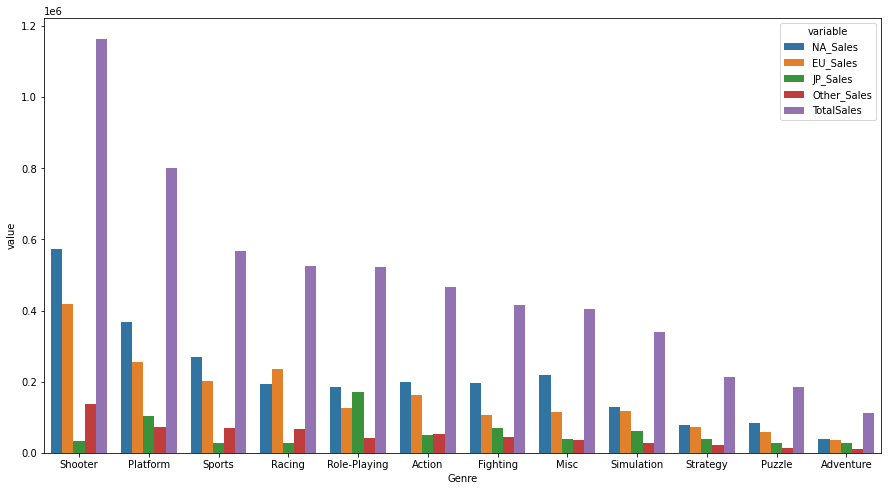

In [380]:
## 지역별 장르에 따른 게임 1개당 출고량
plt.figure(figsize=(15,8))
ax = sns.barplot(data=releaseBYregion_2010_mean.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


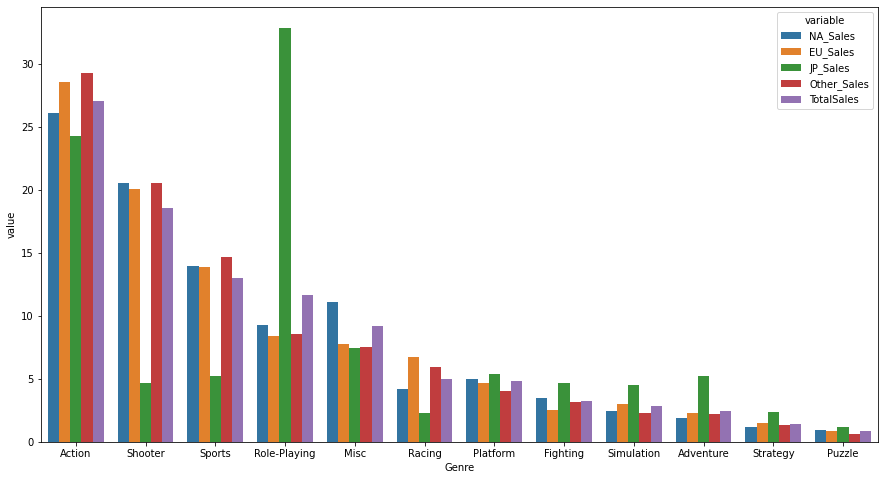

In [385]:
## 지역별 장르에 따라 출고된 비율
plt.figure(figsize=(15,8))
ax = sns.barplot(data=releaseBYregion_2010_ratio.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


#### 2. 연도별 게임의 트렌드가 있을까


###### 장르별 출시된 게임의 수는 연도에 따른 차이가 있을까

In [130]:
# 연도별 출시된 장르 개수

genreBYyear = pd.DataFrame(df.reset_index()\
                            .groupby(['Year_binning','Genre'])['index']\
                            .count()\
                            .reset_index())
genreBYyear.rename({'index':'Freq'},axis=1,inplace=True) 
genreBYyear.sort_values(by=['Year_binning','Freq'], ascending=[True,False],inplace=True)

# Year_binning 별 장르 비율 확인하기
Year_Total = genreBYyear.groupby(['Year_binning'])['Freq'].sum()

genreBYyear = genreBYyear.merge(Year_Total,how='left',
                  on=['Year_binning'])
genreBYyear['ratio'] = genreBYyear['Freq_x'] / genreBYyear['Freq_y'] * 100 
genreBYyear.drop('Freq_y',axis=1,inplace=True) 
genreBYyear.rename({'Freq_x':'Freq'},inplace=True)

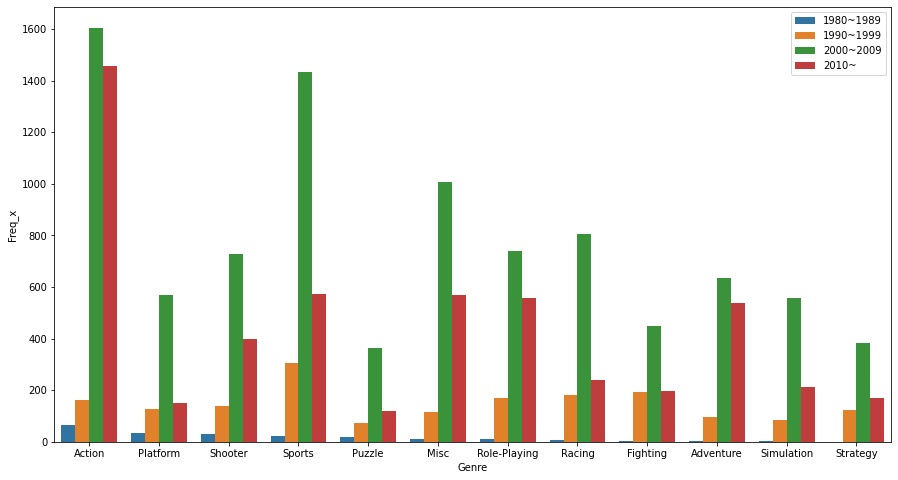

In [132]:
# 연도 별 장르에 따른 게임 출시 수
data = genreBYyear.groupby(['Year_binning','Genre'])['Freq_x']\
        .sum()\
        .reset_index()\
        .sort_values(by=['Year_binning','Freq_x'],ascending=[True,False])


plt.figure(figsize=(15,8))
ax = sns.barplot(data=data,
                 x='Genre', y='Freq_x', hue='Year_binning',
                  )
plt.legend(loc='upper right')


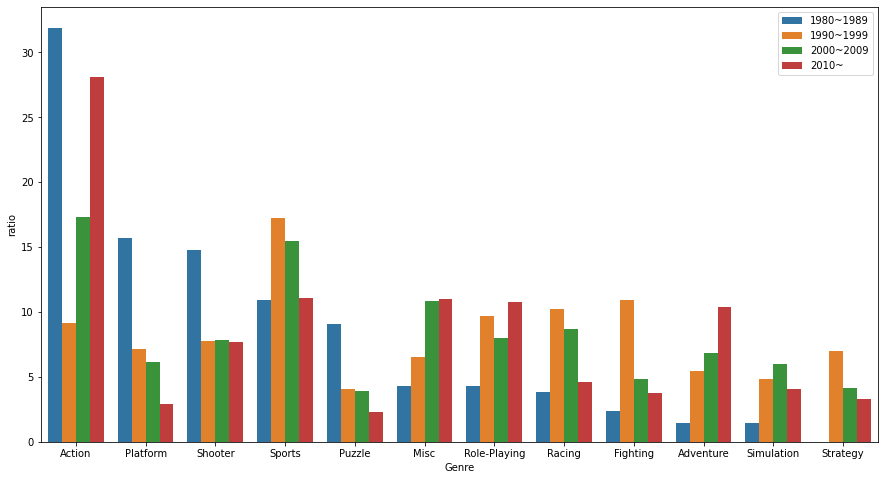

In [133]:
# 연도 별 장르에 따른 게임 출시 비율

data = genreBYyear.groupby(['Year_binning','Genre'])['ratio']\
        .sum()\
        .reset_index()\
        .sort_values(by=['Year_binning','ratio'],ascending=[True,False])


plt.figure(figsize=(15,8))
ax = sns.barplot(data=data,
                 x='Genre', y='ratio', hue='Year_binning',
                  )
plt.legend(loc='upper right')
# plt.title("Sales by Genre ")


In [63]:
pd.DataFrame(genreBYyear.groupby(['Year_binning','Genre'])['Freq_x']\
        .sum()).unstack()

Freq_x                                                  \
Genre        Action Adventure Fighting  Misc Platform Puzzle Racing   
Year_binning                                                          
1980~1989        67         3        5     9       33     19      8   
1990~1999       162        97      193   115      126     72    181   
2000~2009      1605       634      448  1005      569    364    805   
2010~          1455       538      196   568      151    119    238   

                                                              
Genre        Role-Playing Shooter Simulation Sports Strategy  
Year_binning                                                  
1980~1989               9      31          3     23        0  
1990~1999             171     137         86    305      123  
2000~2009             739     728        558   1432      382  
2010~                 559     399        212    574      170

- 연도별 게임 출시 수를 보면,
  - 2000년대 이후 게임 시장이 커짐
  - Action은 다른 장르보다 출시 비율이 높음
  - Platform, Puzzle 장르는 꾸준한 하락세를 보임
  - Role-Playing, Adventure 장르는 지속적인 상승세


##### 장르별 게임 출고량 기준으로 확인해보자.

In [364]:
salesBYyear = pd.DataFrame(df.reset_index()\
                            .groupby(['Year_binning','Genre'])['TotalSales']\
                            .sum()\
                            .reset_index())
# salesBYyear.rename({'index':'Freq'},axis=1,inplace=True) 
salesBYyear.sort_values(by=['Year_binning','TotalSales'], ascending=[True,False],inplace=True)

# Year_binning 별 장르 비율 확인하기
Year_Total = salesBYyear.groupby(['Year_binning'])['TotalSales'].sum()

salesBYyear = salesBYyear.merge(Year_Total,how='left',
                  on=['Year_binning'])
salesBYyear['ratio'] = round(salesBYyear['TotalSales_x'] / salesBYyear['TotalSales_y'] * 100 ,2)
salesBYyear.drop('TotalSales_y',axis=1,inplace=True) 
salesBYyear.rename({'TotalSales_x':'TotalSales'},inplace=True)


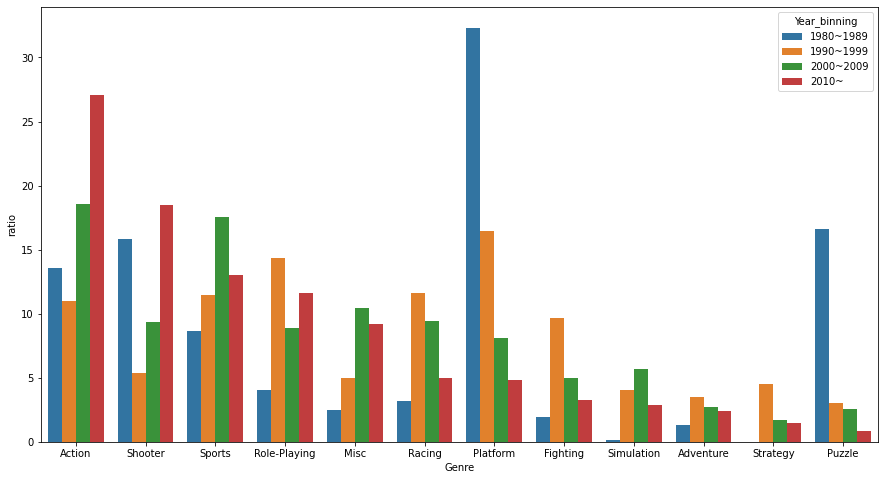

In [365]:
# 연도별 장르의 출고량 비율

plt.figure(figsize=(15,8))
ax = sns.barplot(data=salesBYyear.sort_values(by=['Year_binning','ratio'],ascending=[False,False]),
                 x='Genre', y='ratio', hue='Year_binning')


Text(0, 0.5, 'TotalSales')

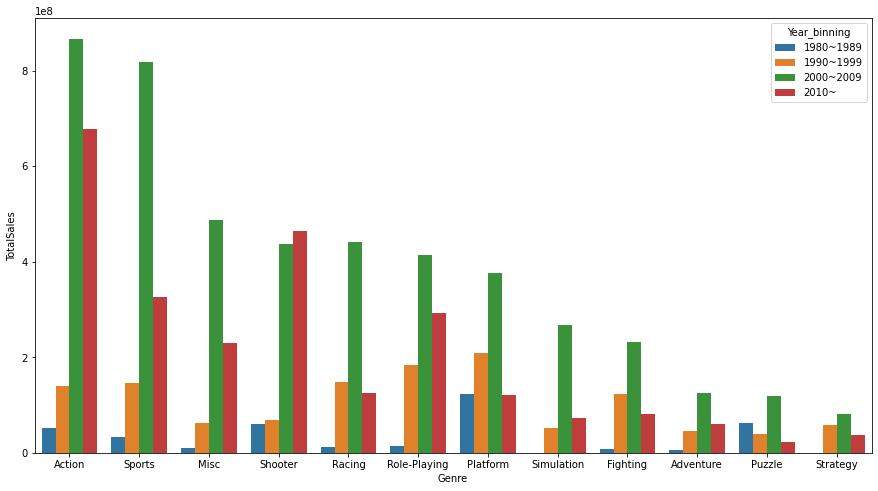

In [366]:
## 장르별 출고량
plt.figure(figsize=(15,8))
ax = sns.barplot(data=salesBYyear.sort_values('TotalSales_x', ascending=False),
                 x='Genre', y='TotalSales_x', hue='Year_binning')
plt.ylabel("TotalSales")

In [147]:
salesBYyear_mean = pd.DataFrame(df.reset_index()\
                            .groupby(['Year_binning','Genre'])['TotalSales']\
                            .mean()\
                            .reset_index())

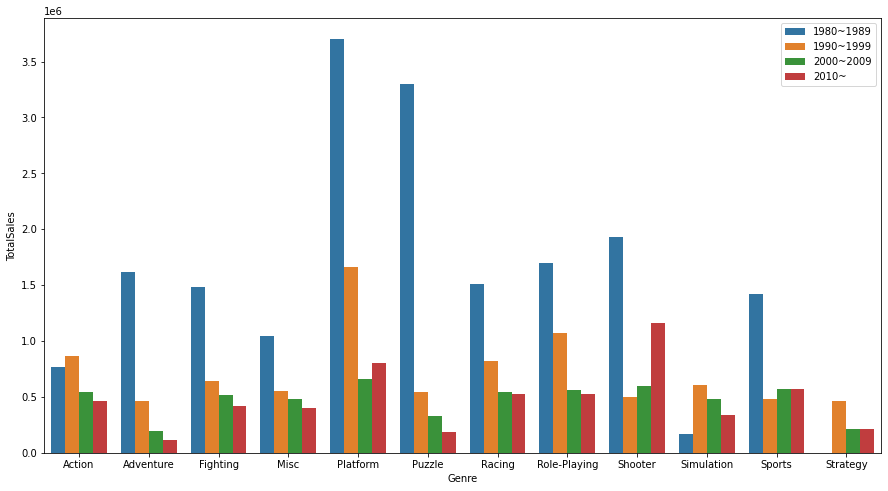

In [148]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=salesBYyear_mean,
                 x='Genre', y='TotalSales', hue='Year_binning')
plt.legend(loc='upper right')

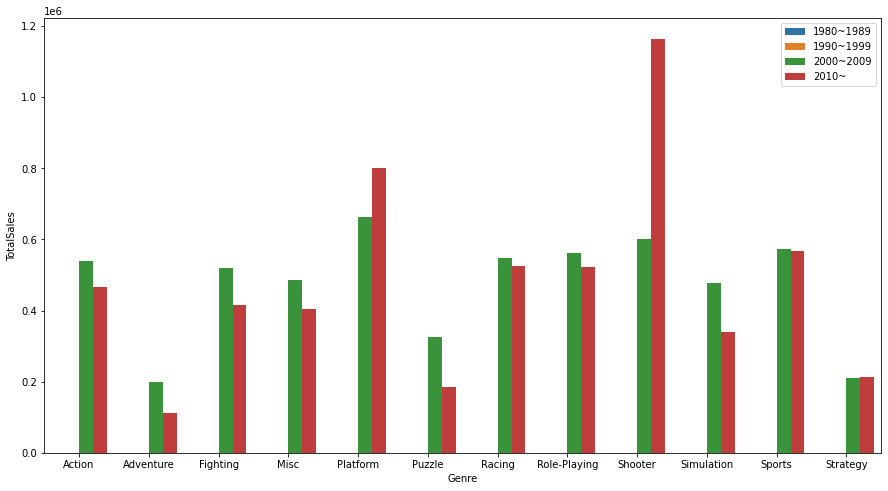

In [157]:
## 2000년대 이후 기준으로
plt.figure(figsize=(15,8))
ax = sns.barplot(data=salesBYyear_mean[salesBYyear_mean['Year_binning'].isin(['2000~2009','2010~'])],
                 x='Genre', y='TotalSales', hue='Year_binning')
plt.legend(loc='upper right')

In [149]:
df.groupby(['Year_binning'])['TotalSales'].describe()

,count,mean,std,min,25%,50%,75%,max
Year_binning,,,,,,,,
1980~1989,210.0,1.801048e+06,4.319481e+06,10000.0,382500.0,830000.0,1520000.0,40240000.0
1990~1999,1768.0,7.225962e+05,1.620029e+06,10000.0,110000.0,270000.0,690000.0,31380000.0
2000~2009,9269.0,5.035106e+05,1.581049e+06,0.0,60000.0,170000.0,460000.0,82740000.0
2010~,5179.0,4.845549e+05,1.217753e+06,10000.0,50000.0,140000.0,410000.0,21820000.0


In [158]:
df.groupby(['Year_binning','Genre'])['TotalSales'].min().unstack()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_binning,,,,,,,,,,,,
1980~1989,20000.0,80000.0,170000.0,230000.0,510000.0,60000.0,270000.0,760000.0,10000.0,30000.0,70000.0,NaN
1990~1999,10000.0,10000.0,10000.0,10000.0,20000.0,20000.0,10000.0,20000.0,20000.0,20000.0,10000.0,10000.0
2000~2009,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,0.0,10000.0,10000.0,10000.0,10000.0,10000.0
2010~,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [160]:
df.groupby(['Year_binning','Genre'])['TotalSales'].median().unstack()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_binning,,,,,,,,,,,,
1980~1989,400000.0,400000.0,1050000.0,1050000.0,1230000.0,1100000.0,1350000.0,1250000.0,1000000.0,40000.0,1420000.0,NaN
1990~1999,315000.0,130000.0,250000.0,200000.0,570000.0,295000.0,300000.0,320000.0,160000.0,305000.0,300000.0,180000.0
2000~2009,210000.0,75000.0,195000.0,160000.0,210000.0,100000.0,180000.0,180000.0,180000.0,160000.0,220000.0,80000.0
2010~,160000.0,35000.0,180000.0,130000.0,230000.0,70000.0,170000.0,150000.0,400000.0,105000.0,200000.0,80000.0


In [152]:
df.groupby(['Year_binning','Genre'])['TotalSales'].max().unstack()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_binning,,,,,,,,,,,,
1980~1989,6500000.0,4380000.0,3020000.0,2140000.0,40240000.0,30260000.0,4160000.0,3870000.0,28310000.0,440000.0,4000000.0,NaN
1990~1999,7600000.0,11180000.0,7180000.0,5310000.0,20620000.0,4840000.0,10950000.0,31380000.0,8090000.0,5110000.0,5020000.0,5450000.0
2000~2009,20810000.0,5550000.0,13040000.0,29010000.0,30010000.0,15300000.0,35830000.0,18350000.0,13520000.0,24750000.0,82740000.0,2740000.0
2010~,21390000.0,3230000.0,7440000.0,21820000.0,10790000.0,2680000.0,12210000.0,15320000.0,14760000.0,9100000.0,8490000.0,4830000.0


Action


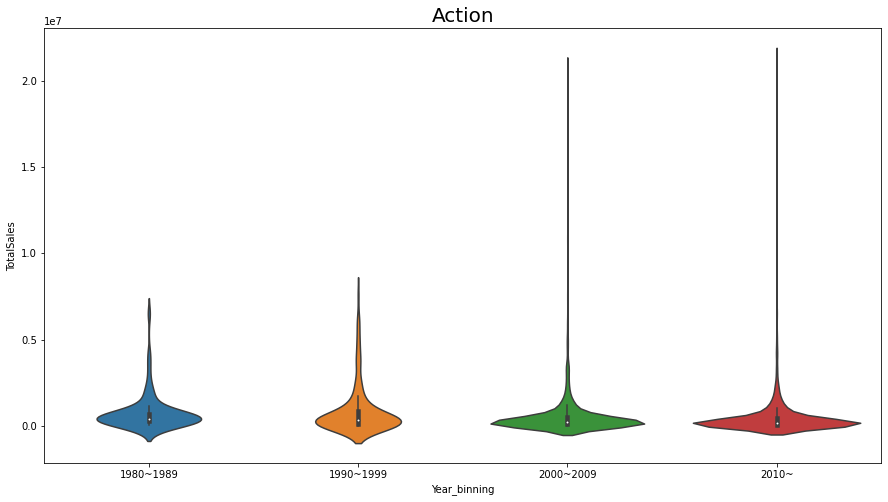

Adventure


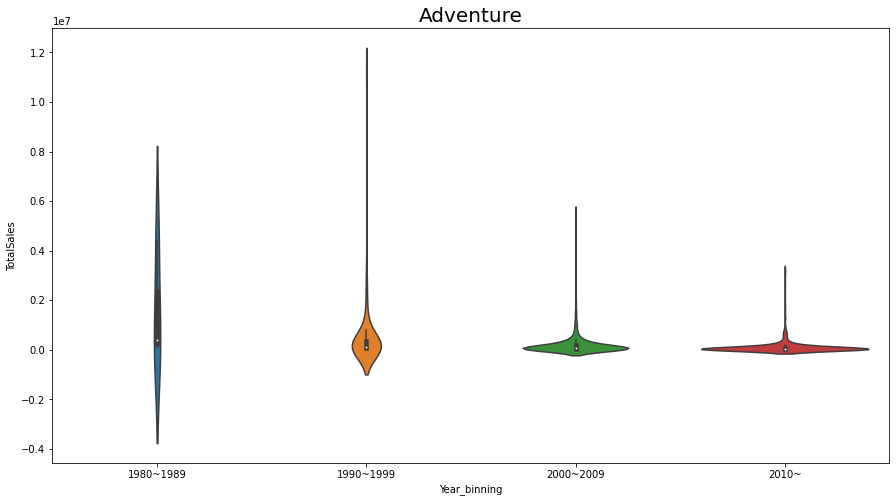

Misc


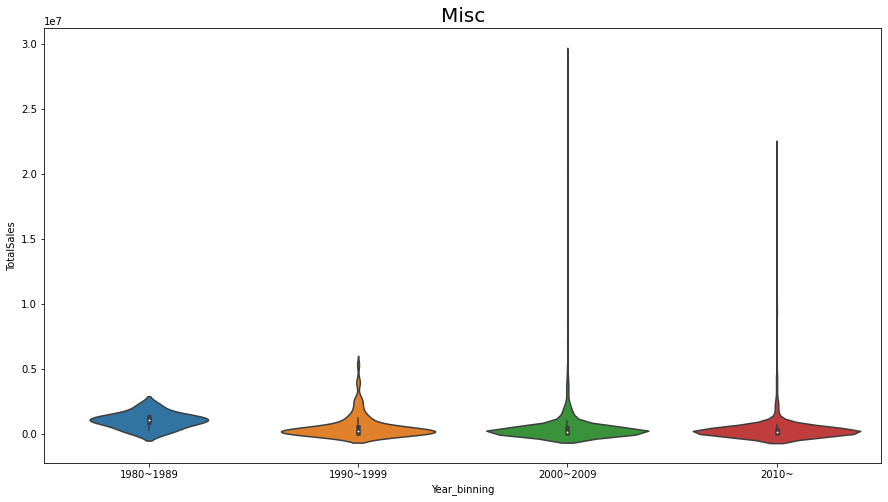

Platform


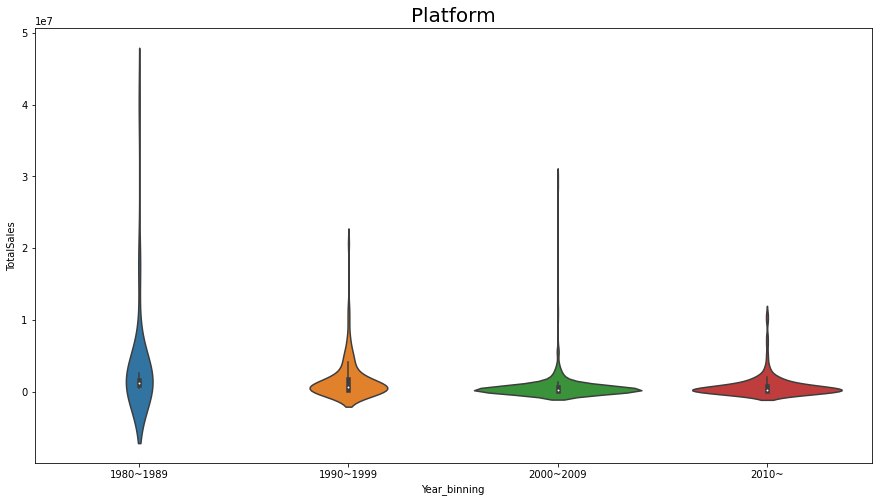

Sports


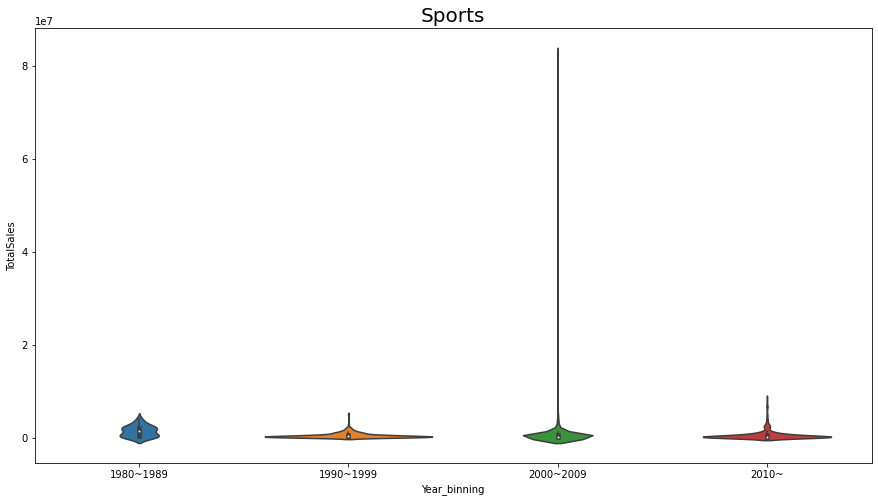

Simulation


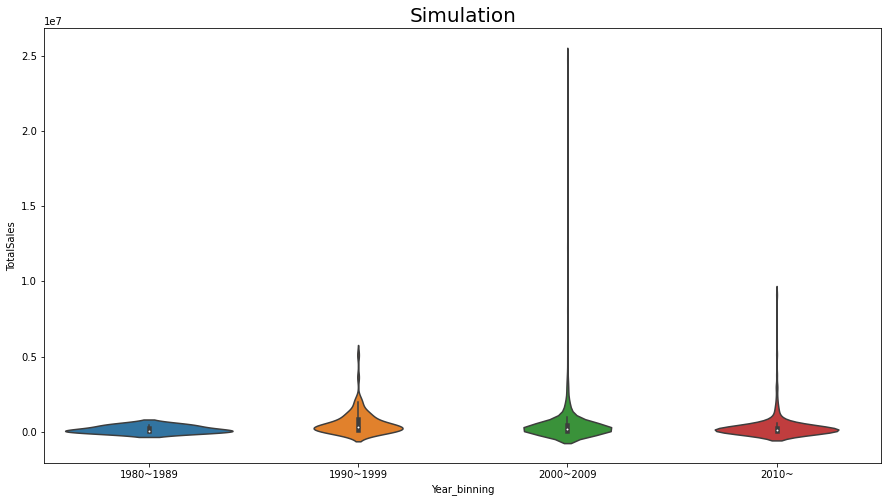

Racing


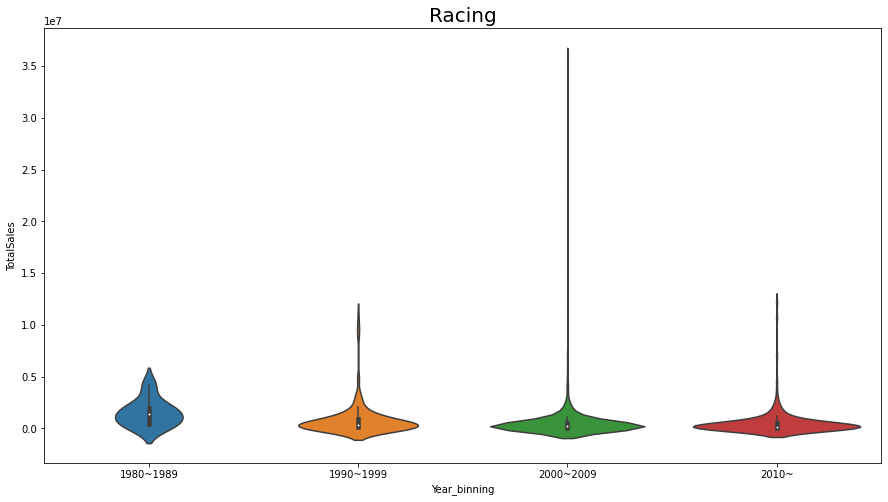

Role-Playing


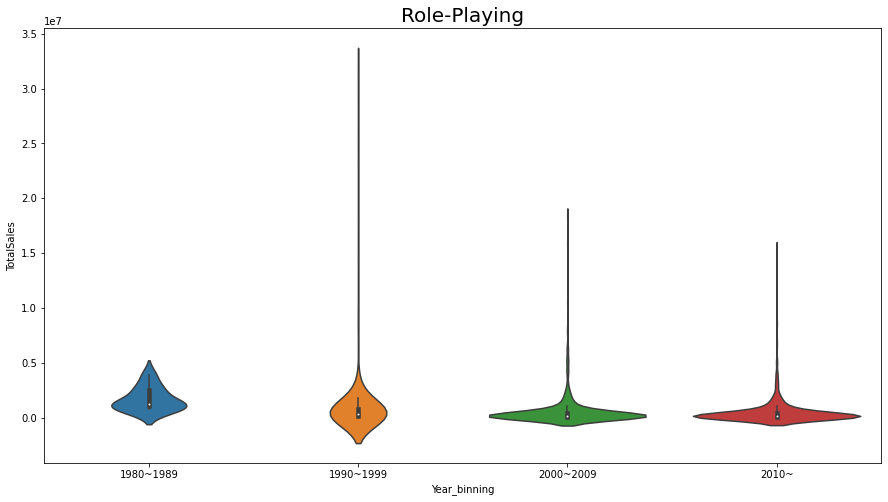

Puzzle


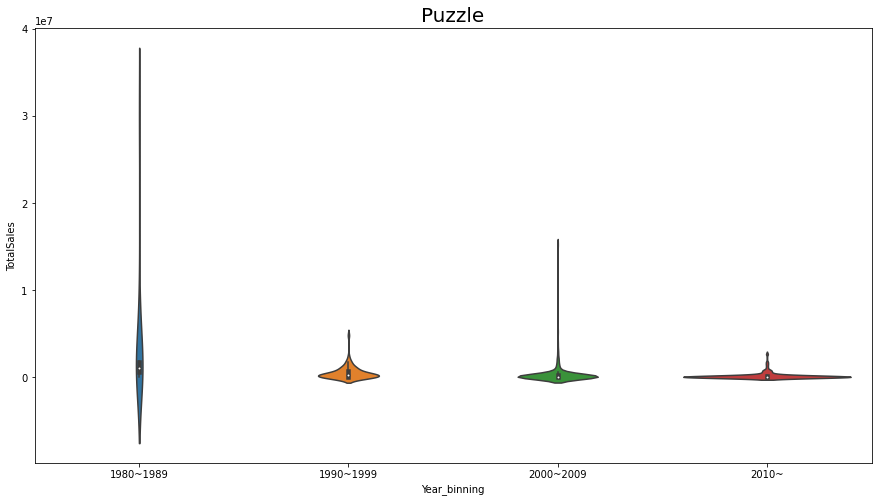

Strategy


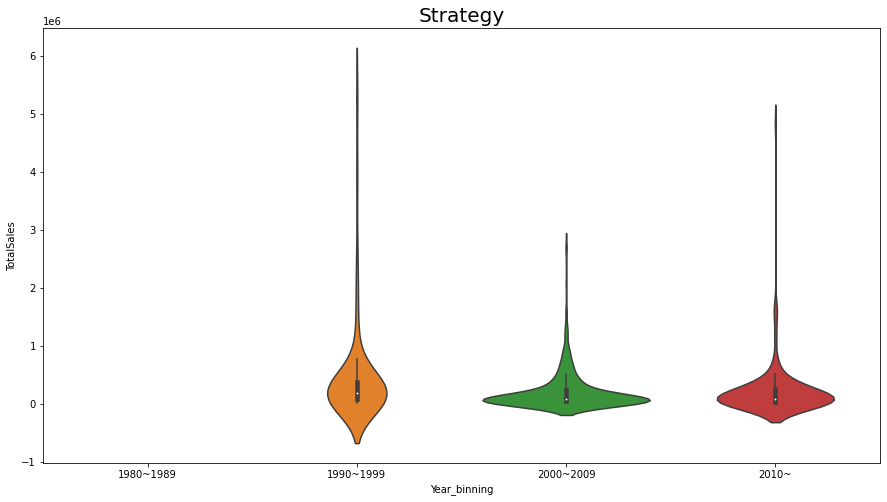

Fighting


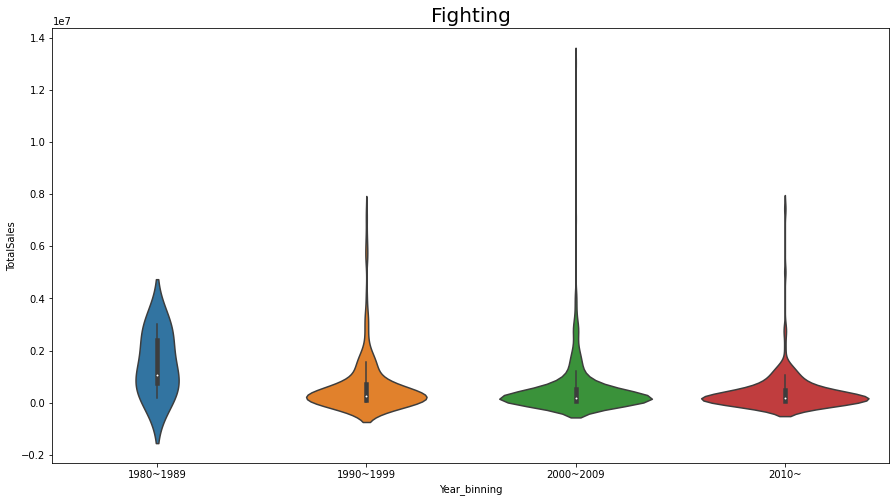

Shooter


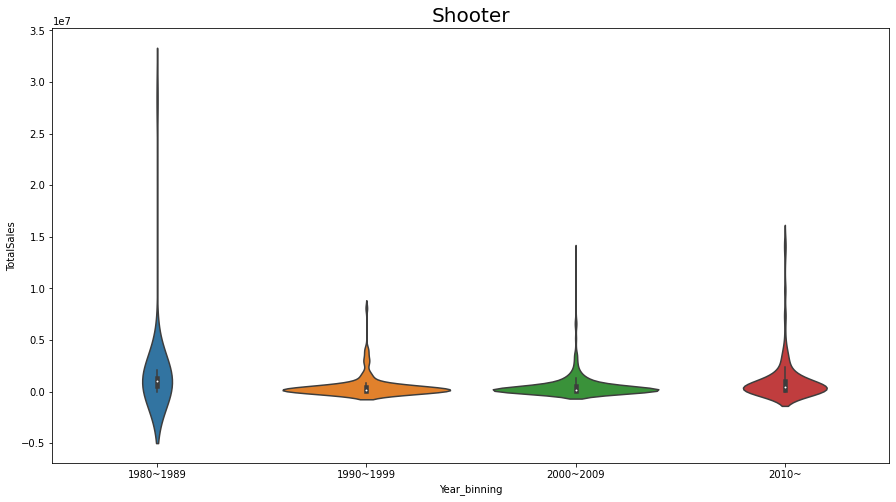

In [182]:
# plt.hist(df[df['Year_binning']=='2000~2009' & df['Genre']=='Action'].TotalSales)

year = df['Year_binning'].unique()
genre = df['Genre'].unique()
for g in genre:
  print(g)
  plt.figure(figsize=(15,8))
  # for y in year:  
    # ax = sns.violinplot(data = df[(df['Year_binning']==y) & (df['Genre']==g)],
    #                     x='')
  ax = sns.violinplot(data = df[(df['Genre']==g)],
                        x='Year_binning',
                        y='TotalSales')
  plt.title(g, size=20)
  plt.show()    

- 연도 별 장르의 출고량 평균을 보면, 1980년도가 가장 높았고 시간이 지날수록 점차 하락하는 추세
- 연도 별 장르에 따른 출고량의 max 값을 살펴보면 해가 지날 수록 출고량이 높아지고 있음을 볼수 있음
  - min값은 1980 년도보다 낮은 값을 가짐
  - median 값 또한 2000년대 이후 낮은 값을 보임 
- 게임의 출시는 2000년대 초중반 가장 많이 출시되었으며, 출시 대비 가장 높은 출고량을 보인 년도는 1980~1990년대 이다.
- 2000년대 이후로 게임의 출시가 많아졌으며 출시된 게임이 많아지며 사용자의 선택의 폭이 넓어지고, 이로 인해 출고량에 어느정도 영향을 미쳤을 것으로 보임
- 하지만, 게임 시장이 커지면서 출고되는 게임 수가 많아졌고 장르 전체의 출고량 평균이 감소하고 있다고 볼 수 있음  

In [359]:
# 장르별 출시 게임 수와 출고량의 관계
genre_sales_corr = genreBYyear.merge(salesBYyear,
                  on=['Year_binning','Genre'])
genre_sales_corr.drop(['ratio_x','ratio_y'],axis=1,inplace=True)
genre_sales_corr.corr()

,Freq_x,TotalSales_x
Freq_x,1.000000,0.934702
TotalSales_x,0.934702,1.000000


- 장르별 출시되는 게임의 수는 출고량과 높은 상관관계를 보임

##### 3. 출고량이 높은 게임에 대한 분석 및 시각화

##### Top100 살펴보기

##### 1. 전체기준 

In [172]:
top100 = df.sort_values('TotalSales',ascending=False)[:100]
top100.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,Year_binning
2908,Wii Sports,Wii,2006,Sports,Nintendo,41490000.0,29020000.0,3770000.0,8460000.0,82740000.0,2000~2009
4199,Super Mario Bros.,NES,1985,Platform,Nintendo,29080000.0,3580000.0,6810000.0,770000.0,40240000.0,1980~1989
12579,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000.0,12880000.0,3790000.0,3310000.0,35830000.0,2000~2009
3352,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000.0,11010000.0,3280000.0,2960000.0,33000000.0,2000~2009
7829,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000.0,8890000.0,10220000.0,1000000.0,31380000.0,1990~1999


In [248]:

## TOP 100 내 장르별 개수 BY 2010년 이후
total_2010 = df.loc[df['Year_binning']=='2010~',:].sort_values(['TotalSales'],ascending=False)
top100_2010 = df.loc[df['Year_binning']=='2010~',:].sort_values(['TotalSales'],ascending=False)[:100]

No handles with labels found to put in legend.


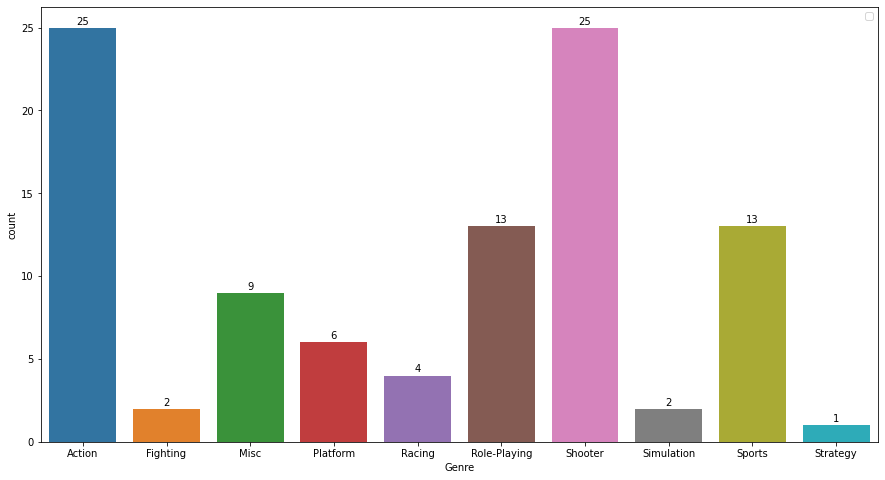

In [249]:
# Top 100 
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Genre',
              data=top100_2010,
              order=['Action', 'Fighting', 'Misc', 'Platform', 'Racing', 'Role-Playing',
       'Shooter', 'Simulation', 'Sports', 'Strategy'])

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.2, height,
          ha = 'center', size=10)  
plt.legend(loc='upper right')


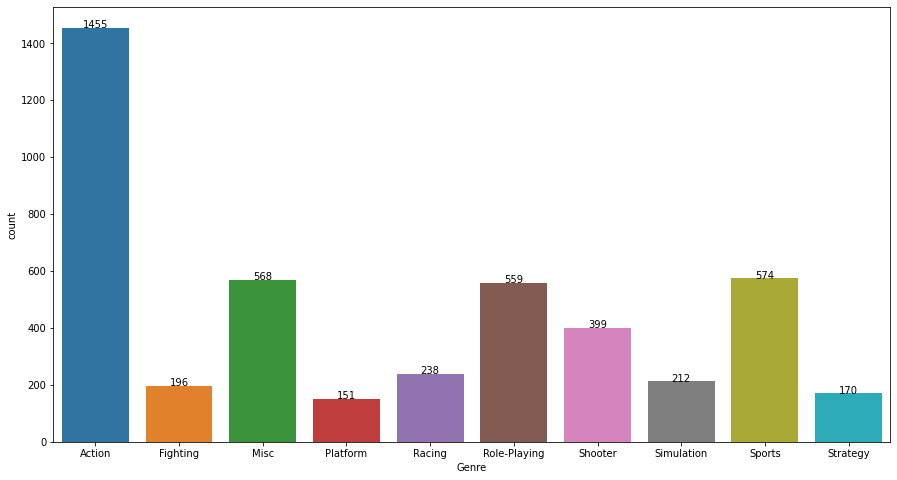

In [250]:
# 전체 

plt.figure(figsize=(15,8))
ax = sns.countplot(x='Genre',
              data=total_2010,
              order=['Action', 'Fighting', 'Misc', 'Platform', 'Racing', 'Role-Playing',
       'Shooter', 'Simulation', 'Sports', 'Strategy'])

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.2, height,
          ha = 'center', size=10)
  


In [251]:
## 전체 장르별 출고량 비율
total_2010_grouped = total_2010.reset_index().groupby(['Genre'])['index'].count().reset_index()
top100_2010_grouped = top100_2010.reset_index().groupby(['Genre'])['index'].count().reset_index()
top100_2010_grouped = total_2010_grouped.merge(top100_2010_grouped, on='Genre')
top100_2010_grouped['ratio'] = round(top100_2010_grouped['index_y'] / top100_2010_grouped['index_x'] * 100,2)

No handles with labels found to put in legend.


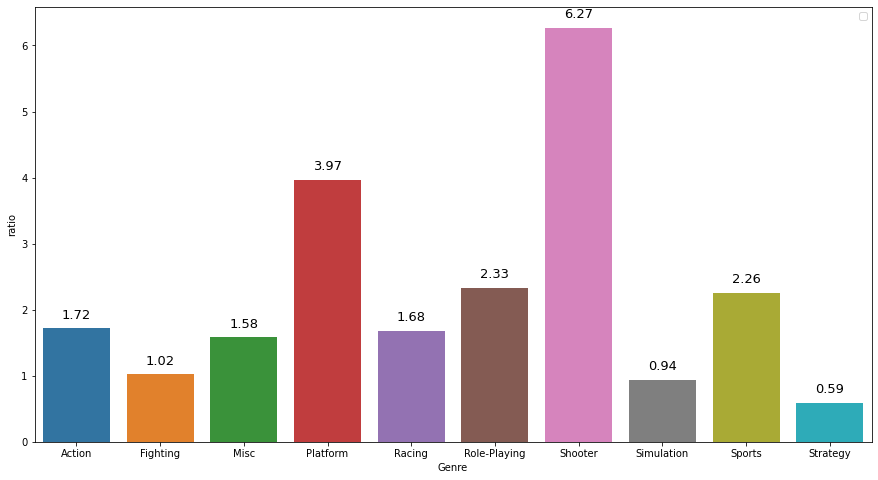

In [252]:

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Genre',
              y='ratio',
              data=top100_2010_grouped)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/ 2.,
          height+0.15, height,
          ha='center',
          size=13)
  
plt.legend(loc='upper right')


- 2010년 이후 기준으로 Action, Shooter 는 각 25개씩 Top100에 위치
  - Top100의 절반이 Action과 Shooter 
- 전체 출시 수 대비 Top100 내에 들어온 비율로 보았을 때, Shooter, Platform 이 각각 6.27%, 3.97%로 높음
- Action 장르는 전체 출시 수에 비해 낮은 비율로 Top 100에 위치

In [345]:
## 지역별 연도별 장르 선호도 -> 출고량 기준

# 전체, 지역별 출고량 Mean 가져오기
# 해당 코드 사용 X
def region(r):

  region_sum = top100_2010.groupby('Genre')[r].sum() # SUM 기준 
  region_mean = top100_2010.groupby(['Genre'])[r].mean() # Mean 기준
  total = top100_2010.groupby('Genre')[r].mean().sum()

  return pd.DataFrame(region_mean), pd.DataFrame(round((region_mean / total) * 100,2)), pd.DataFrame(region_sum)

top100_region_sum = pd.DataFrame(top100_2010['Genre'].unique(), columns=['Genre'])
top100_region_ratio = pd.DataFrame(top100_2010['Genre'].unique(), columns=['Genre'])
top100_region_mean = pd.DataFrame(top100_2010['Genre'].unique(), columns=['Genre'])

sales = top100_2010.columns[top100_2010.columns.str.contains('Sales')]

for r in sales:
  
  mean, ratio, sum = region(r)
  
  ratio.sort_values(ascending=False,inplace=True, by=[r])

  # 장르별 선호 비율
  top100_region_ratio = top100_region_ratio.merge(ratio,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=ratio.index)
  
  top100_region_mean = top100_region_mean.merge(mean,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=mean.index)
  
  top100_region_sum = top100_region_sum.merge(sum,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=sum.index)
  


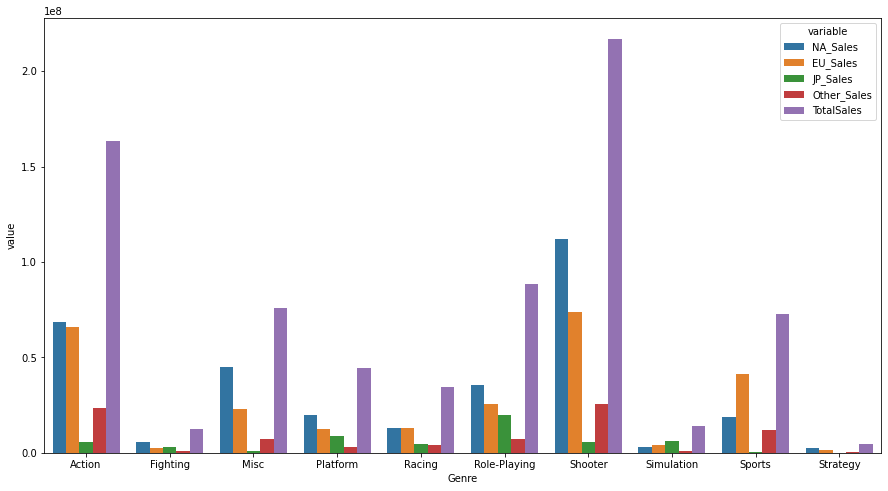

In [346]:
# Top100 지역별 출고 합계
plt.figure(figsize=(15,8))
ax = sns.barplot(data=top100_region_sum.sort_values('Genre').melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')

plt.show()


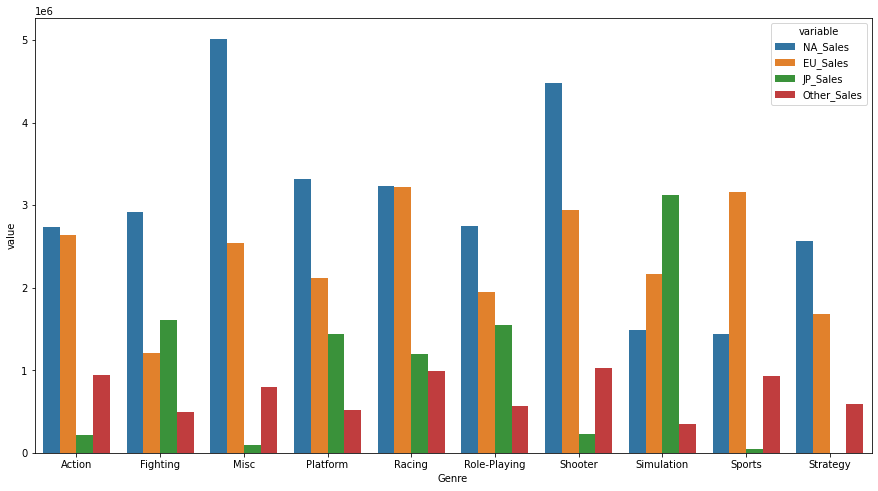

In [309]:
# Top100 지역별 출고 평균
plt.figure(figsize=(15,8))
ax = sns.barplot(data=top100_region_mean.sort_values('Genre').melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')

plt.show()


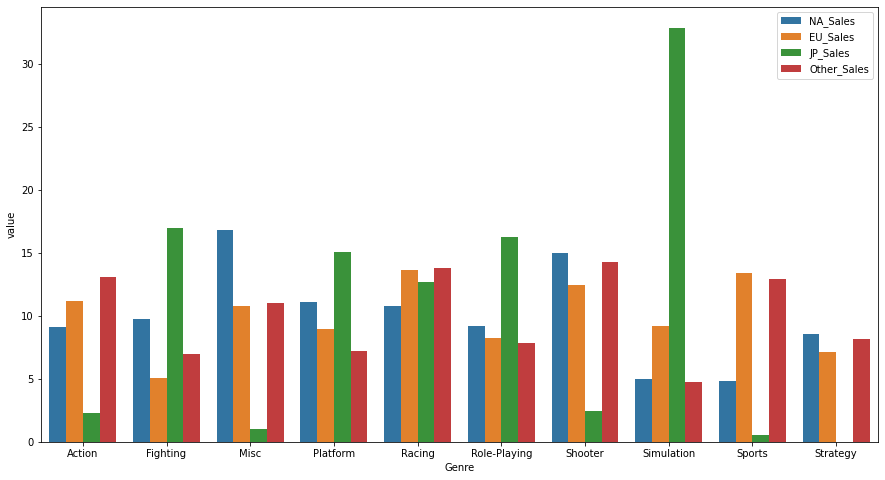

In [310]:
# Top100 지역별 출고 비율
plt.figure(figsize=(15,8))
ax = sns.barplot(data=top100_region_ratio.sort_values('Genre').melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')
plt.legend(loc='upper right')
plt.show()



- 전체 출고량과 동일하게 TOP100 출고량 또한 북미와 유럽 지역에서 대부분을 차지
- 이례적으로 Simulation 장르는 북미, 유럽 지역보다 Japan 지역에서 많은 양이 출고
- Shooter, Action 장르의 경우 전체적인 출고량은 높지만 Japan 지역에서는 큰 인기를 끌지 못함

### 장르와 플랫폼은 관계가 있을까?
- H0 : 장르와 플랫폼은 관계가 없다.
- H1 : 장르와 플랫폼은 관계가 있다.


In [317]:
import scipy.stats as stats

In [318]:
genre_platform = pd.crosstab(df['Genre'],df['Platform'])
stats.chi2_contingency(observed=genre_platform)

(5838.549378277951,
 0.0,
 330,
 array([[2.32268355e+01, 6.00694022e-01, 1.01317058e+02, 1.04120297e+01,
         4.29095763e+02, 1.96226714e+01, 1.58182759e+02, 1.10727931e+02,
         5.40624620e+00, 2.00231341e-01, 6.30728723e+01, 1.96226714e+01,
         2.40277609e+00, 1.89218617e+02, 2.00231341e-01, 2.38075064e+02,
         4.30697614e+02, 2.63304213e+02, 6.70774991e+01, 2.41478997e+02,
         8.20948496e+01, 3.46400219e+01, 1.20138804e+00, 4.78552904e+01,
         4.00462681e-01, 1.20138804e+00, 2.61902593e+02, 2.86330817e+01,
         2.50889870e+02, 1.63789237e+02, 4.24490442e+01],
        [8.98283210e+00, 2.32314623e-01, 3.91837331e+01, 4.02678680e+00,
         1.65950079e+02, 7.58894436e+00, 6.11761841e+01, 4.28233289e+01,
         2.09083161e+00, 7.74382077e-02, 2.43930354e+01, 7.58894436e+00,
         9.29258493e-01, 7.31791063e+01, 7.74382077e-02, 9.20740290e+01,
         1.66569585e+02, 1.01831243e+02, 2.59417996e+01, 9.33904785e+01,
         3.17496652e+01, 1.3396809

- P-value = 0.0, 귀무가설 기각, 대립가설 채택 
- 플랫폼과 장르간에 차이가 존재한다. 

### 연도와 플랫폼은 관계가 있을까?
- H0 : 연도와 플랫폼은 관계가 없다.
- H1 : 연도와 플랫폼은 관계가 있다.


In [319]:
year_platform = pd.crosstab(df['Year_binning'],df['Platform'])
stats.chi2_contingency(observed=year_platform)

(33449.40514668394,
 0.0,
 90,
 array([[1.48301473e+00, 3.83538293e-02, 6.46901254e+00, 6.64799708e-01,
         2.73974187e+01, 1.25289176e+00, 1.00998417e+01, 7.06988920e+00,
         3.45184464e-01, 1.27846098e-02, 4.02715208e+00, 1.25289176e+00,
         1.53415317e-01, 1.20814562e+01, 1.27846098e-02, 1.52009010e+01,
         2.74996956e+01, 1.68117618e+01, 4.28284427e+00, 1.54182394e+01,
         5.24169000e+00, 2.21173749e+00, 7.67076586e-02, 3.05552173e+00,
         2.55692195e-02, 7.67076586e-02, 1.67222696e+01, 1.82819920e+00,
         1.60191160e+01, 1.04578108e+01, 2.71033727e+00],
        [1.24855717e+01, 3.22902715e-01, 5.44629246e+01, 5.59698040e+00,
         2.30660173e+02, 1.05481554e+01, 8.50310483e+01, 5.95217338e+01,
         2.90612444e+00, 1.07634238e-01, 3.39047851e+01, 1.05481554e+01,
         1.29161086e+00, 1.01714355e+02, 1.07634238e-01, 1.27977109e+02,
         2.31521247e+02, 1.41539023e+02, 3.60574699e+01, 1.29806892e+02,
         4.41300377e+01, 1.86207232

- P-value = 0.0, 귀무가설 기각, 대립가설 채택 
- 플랫폼과 연도간에 관계가 있다. 

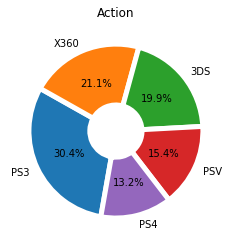

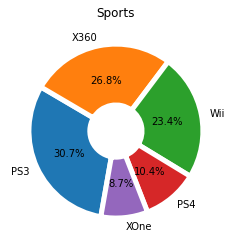

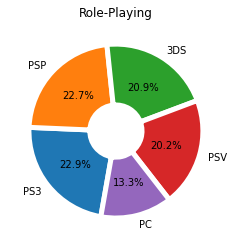

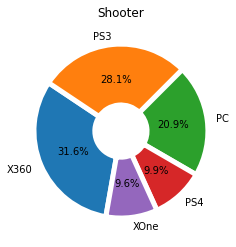

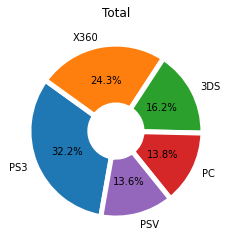

In [322]:
data = df[(df['Year_binning']=='2010~') & (df['Genre'].isin(['Action','Shooter','Sports','Role-Playing']))]

genre_platform = pd.DataFrame(data.reset_index().groupby(['Genre','Platform'])['index'].count()).reset_index()
genre_platform.rename({'index':'Freq'},axis=1,inplace=True)
genre = data['Genre'].unique()
for g in genre:
  cond = (genre_platform['Genre']==g)
  genre_top5 = genre_platform[cond].groupby(['Platform'])['Freq'].sum().sort_values(ascending=False)[:5].reset_index()
  wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
  plt.pie(genre_top5['Freq'], labels=genre_top5['Platform'],startangle=260, autopct='%1.1f%%',counterclock=False, wedgeprops=wedgeprops)
  
  plt.title(g)
  plt.show()

total_platform = pd.DataFrame(data.reset_index().groupby(['Platform'])['index'].count().sort_values(ascending=False)[:5]).reset_index()
total_platform.rename({'index':'Freq'},axis=1,inplace=True)
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(total_platform['Freq'], labels=total_platform['Platform'],startangle=260, autopct='%1.1f%%',counterclock=False, wedgeprops=wedgeprops)
plt.title("Total")
plt.show()



- 검증을 통해 장르별 플랫폼, 연도별 플랫폼은 서로 차이가 있음을 확인
- 2010년 이후 데이터를 기준으로 장르별 출시된 플랫폼 종류 확인
  - Action : PS3 or X360
  - Shooter : X360 or PS3
  - Role-Playing : PS3 or PSP

No handles with labels found to put in legend.


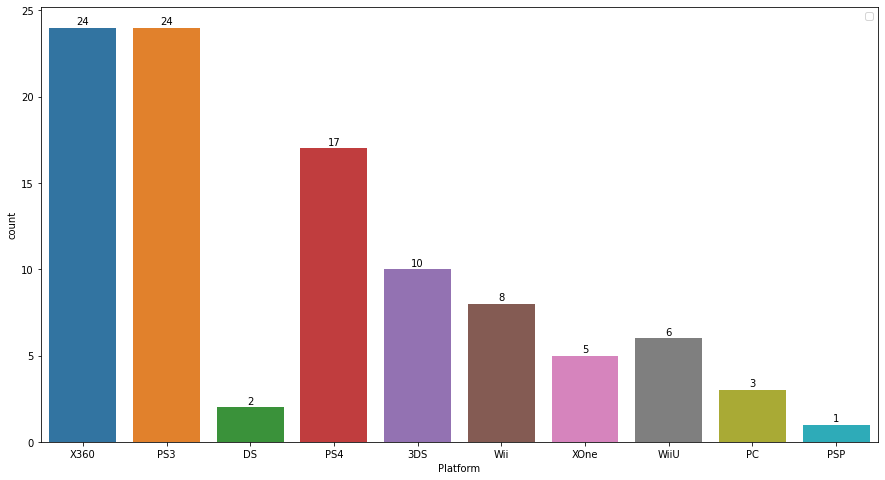

In [347]:

## TOP 100 내 장르별 개수 
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Platform',
              data=top100_2010)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.2, height,
          ha = 'center', size=10)
plt.legend(loc='upper right')

# sns.countplot()
